In [3]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

import sys
import os
parent_dir = os.path.dirname(os.getcwd())  
sys.path.append(parent_dir)

from bert_models.bert_regressor import BertMultiOutputRegressor
from bert_models.dataset import EssayDataset


In [4]:
df = pd.read_csv("C:/Users/Vijay/Apy/A_LSTM-BERT/data/CELA.csv")

labels = [
    "Grammar", "Lexical", "Global Organization",
    "Local Organization", "Supporting Ideas", "Holistic"
]

X_train, X_val, y_train, y_val = train_test_split(
    df["Essays"].tolist(),
    df[labels].values,
    test_size=0.2,
    random_state=42
)


In [5]:
train_ds = EssayDataset(X_train, y_train)
val_ds = EssayDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=4)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertMultiOutputRegressor(num_outputs=6).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.MSELoss()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

C:\Users\Vijay\Documents\jupy\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vijay\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
EPOCHS = 8
best_rmse = float("inf")

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        loss = loss_fn(outputs, batch["labels"].to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    preds, gold = [], []
    with torch.no_grad():
        for batch in val_loader:
            out = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds.append(out.cpu())
            gold.append(batch["labels"])

    preds = torch.cat(preds).numpy()
    gold = torch.cat(gold).numpy()

    rmse = mean_squared_error(gold, preds, squared=False)
    print(f"Epoch {epoch+1} | RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        torch.save(model.state_dict(), "C:/Users/Vijay/Apy/A_LSTM-BERT/models/bert_cela_regressor.pt")


Epoch 1 | RMSE: 1.2718
Epoch 2 | RMSE: 1.1379
Epoch 3 | RMSE: 1.0596
Epoch 4 | RMSE: 1.0046
Epoch 5 | RMSE: 0.9670
Epoch 6 | RMSE: 0.9373
Epoch 7 | RMSE: 0.9185
Epoch 8 | RMSE: 0.9060


In [10]:
import matplotlib.pyplot as plt

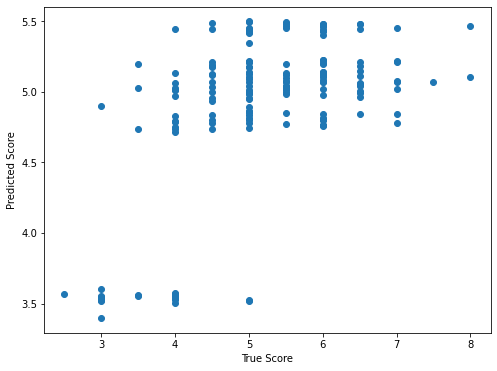

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
y_true = gold
y_pred = preds
plt.scatter(y_true, y_pred)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.show()


# In the final app.py calibration is done!
## Reason for Calibration of Model Outputs

During testing of the essay scoring application, it was observed that even high-quality essays were receiving unexpectedly low scores (e.g., not exceeding 5.5 out of 8). This indicated that the raw outputs from the BERT-based regression model were **not aligned with the intended scoring scales** of the CELA dataset.

### Observations
- The model was trained on a dataset with very few high rated essays, which caused outputs to fall within a limited range.
- Directly using these raw outputs led to **underestimation of scores**, even for exemplary essays.
- Feedback based on these unscaled scores could be misleading to users.

### Implemented Solution
To address this, a **calibration step** was introduced:

1. **Selective Calibration for Parameter Scores**  
   Calibration is applied only to specific parameters—Grammar, Lexical, Global Organization, Local Organization, and Supporting Ideas—to adjust model outputs proportionally. This ensures that moderately scored essays are scaled appropriately without inflating poor essays.

2. **Maximum Score Enforcement**  
   The scores are strictly capped at their respective maximum values (8 for most parameters, 5 for Holistic), preventing unrealistic scores due to model or calibration effects.

3. **No Calibration for Holistic Score**  
   The Holistic score represents the overall essay quality and is kept uncalibrated to preserve its authenticity as a summary measure of essay performance.

4. **Lower Bound Protection**  
   Essays with very low quality won't receive calibration, they will only receive scores that reflect their performance, avoiding artificially inflated ratings.

1. Each raw score predicted by the model is scaled proportionally to match the **maximum possible score** for that parameter.
2. A scaling factor is applied to bring the model output closer to the true score range (e.g., 0–8 for Grammar, Lexical, etc.).
3. This ensures that:
   - High-quality essays can receive scores near the upper limit.
   - low - quality essays can receive low scores.
   - Feedback is consistent with the displayed scores.
   - Users receive a realistic evaluation of essay quality.

### Benefits
- Aligns model outputs with the original scoring rubric of the dataset.
- Prevents systematic underestimation of essay quality.
- Improves user trust and interpretability of both **scores** and **feedback**.
